## automating the regularization parameter tuning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import wobble
import tensorflow as tf
from tqdm import tqdm

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
starname = '51peg'
data = wobble.Data(starname+'_e2ds.hdf5', filepath='data/', orders=[10])

In [3]:
model = wobble.Model(data)
model.add_star('star')
K = 0
model.add_telluric('tellurics', rvs_fixed=True, variable_bases=K)
print(model)

Model consisting of the following components: 
star: RVs variable; 0 variable basis components
tellurics: RVs fixed; 0 variable basis components


In [4]:
# from hand-tuning
model.components[1].L2_template = 1.e7
model.components[1].L2_basis_vectors = 1.e7
model.components[0].L1_template = 1.e1
model.components[0].L2_template = 1.e1

In [5]:
def fit_rvs_only(model, data, r):
    synth = model.synthesize(r)
    nll = 0.5*tf.reduce_sum(tf.square(tf.boolean_mask(data.ys[r], data.epoch_mask) 
                                      - tf.boolean_mask(synth, data.epoch_mask)) 
                            * tf.boolean_mask(data.ivars[r], data.epoch_mask)) 
    
    # set up optimizers: 
    for c in model.components:
        if not c.rvs_fixed:
            c.gradients_rvs = tf.gradients(nll, c.rvs_block[r])
            c.opt_rvs = tf.train.AdamOptimizer(c.learning_rate_rvs).minimize(nll, 
                            var_list=[c.rvs_block[r]])
        if c.K > 0:
            c.gradients_basis = tf.gradients(nll, c.basis_weights[r])
            c.opt_basis = tf.train.AdamOptimizer(c.learning_rate_basis).minimize(nll, 
                            var_list=c.basis_weights[r]) 
        
        
    session = wobble.get_session()
    session.run(tf.global_variables_initializer())
    
    results = wobble.Results(model=model, data=data)

    # optimize:
    for i in tqdm(range(100)):         
        for c in model.components:
            if not c.rvs_fixed:            
                session.run(c.opt_rvs) # optimize RVs
            if c.K > 0:
                session.run(c.opt_basis) # optimize variable components
    results.copy_model(model) # update
    return results
    

In [8]:
validation_epochs = np.random.choice(data.N, data.N//10, replace=False)
training_epochs = np.delete(np.arange(data.N), validation_epochs)
    
training_data = copy.copy(data)
training_data.epoch_mask = np.isin(np.arange(data.N), training_epochs)
validation_mask = np.isin(np.arange(data.N), validation_epochs)
validation_data = copy.copy(data)
validation_data.epoch_mask = validation_mask

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False  True False False False False  True
  True False False False False False  True False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False  True False False  True False False]


In [9]:
name = 'L2_template'
c = model.components[0]

In [10]:
current_value = getattr(c, name)
grid = np.logspace(-2.0, 2.0, num=5) * current_value
chisqs_grid = np.zeros_like(grid)
print(grid)

[1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]


In [12]:
i,val = 0,1.e-1
r = 0
setattr(c, name, val)
for co in model.components:
    co.template_exists[r] = False # force reinitialization at each iteration
results_train = wobble.optimize_order(model, training_data, r)


  8%|▊         | 8/100 [00:04<00:46,  1.99it/s]
Exception in thread Thread-18:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


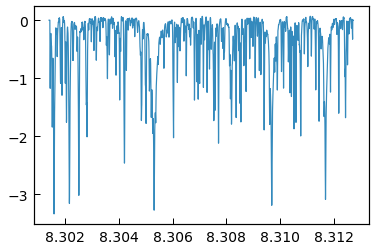

In [17]:
plt.plot(results_train.star_template_xs[0], results_train.star_template_ys[0]);

In [21]:
results_train.star_rvs_block[0] - results_train.bervs

array([6041.68447292, 6045.30946775, 6057.69878793, 6053.58841383,
       6056.39560513, 6064.50775093, 6052.24944236, 6074.32724245,
       6065.81756897, 6064.11465169, 6077.14311163, 6063.00237342,
       6060.82481153, 6064.11102354, 6036.59457825, 6035.68032121,
       6024.10601227, 6053.35008466, 6048.97089766, 6046.28533705,
       6033.14321783, 6040.96536276, 6041.77077106, 6041.18328045,
       6052.63407325, 6049.63107031, 6040.48979498, 6039.28315743,
       6029.35574364, 6026.37597157, 6040.48979498, 6025.36793169,
       6032.69679259, 6039.61373278, 6032.91147635, 6040.48979498,
       6040.48979498, 6068.91889106, 6035.57263065, 6038.4239976 ,
       6013.99799815, 6015.73341028, 6040.48979498, 6020.05514677,
       6011.54159966, 6019.55490923, 6052.20948023, 6040.48979498,
       6025.200427  , 6060.01650324, 6046.3690469 , 6024.53356683,
       5992.8466932 , 6001.52816678, 6004.93893384, 6017.11633995,
       6005.60942104, 6020.10604667, 5981.07648681, 6006.74888

In [22]:
results = fit_rvs_only(model, validation_data, 0)

100%|██████████| 100/100 [00:04<00:00, 23.61it/s]


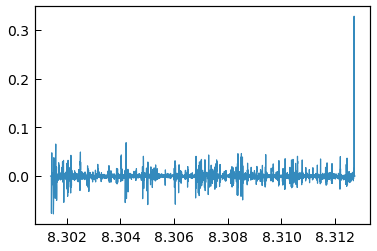

In [24]:
plt.plot(results.star_template_xs[0], results.star_template_ys[0] - results_train.star_template_ys[0]);

In [26]:
results.star_rvs_block[0] - results_train.star_rvs_block[0]

array([ -1.19467794,  -4.81967277, -17.20899294, -13.09861884,
       -15.90581015, -24.01795595, -11.75964737, -33.83744747,
       -25.32777399, -23.62485671, -36.65331665, -22.51257844,
       -20.33501655, -23.62122855,   3.89521673,   4.80947377,
        16.38378271, -12.86028968,  -8.48110267,  -5.79554207,
         7.34657716,  -0.47556778,  -1.28097608,  -0.69348547,
       -12.14427826,  -9.14127533,  10.93245622,   1.20663755,
        11.13405134,  14.11382341,   6.25821797,  15.12186329,
         7.7930024 ,   0.8760622 ,   7.57831863,  20.99368949,
        13.74013473, -28.42909608,   4.91716433,   2.06579738,
        26.49179683,  24.75638471,   8.37859867,  20.43464822,
        28.94819532,  20.93488575, -11.71968524,  10.48797095,
        15.28936798, -19.52670825,  -5.87925192,  15.95622816,
        47.64310178,  38.9616282 ,  35.55086114,  23.37345503,
        34.88037394,  20.38374831,  59.41330818,  33.7409073 ,
        41.69131307,  38.16004699,  22.74822485,  29.81

In [5]:
def improve_regularization(c, model, data, r, names=None):
    if names is None:
        names = ['L1_template', 'L2_template']
        if c.K > 0:
            names.append(['L1_basis_vectors', 'L2_basis_vectors', 'L2_basis_weights'])
            
    validation_epochs = np.random.choice(data.N, data.N//10, replace=False)
    training_epochs = np.delete(np.arange(data.N), validation_epochs)
    
    training_data = copy.copy(data)
    training_data.epoch_mask = np.isin(np.arange(data.N), training_epochs)
    validation_mask = np.isin(np.arange(data.N), validation_epochs)
    validation_data = copy.copy(data)
    validation_data.epoch_mask = validation_mask
    
    for name in names:
        current_value = getattr(c, name)
        grid = np.logspace(-2.0, 2.0, num=5) * current_value
        chisqs_grid = np.zeros_like(grid)
        for i,val in enumerate(grid):
            setattr(c, name, val)
            for co in model.components:
                co.template_exists[r] = False # force reinitialization at each iteration
                
            results_train = wobble.optimize_order(model, training_data, r)
            
            results = fit_rvs_only(model, validation_data, r)
            
            chisqs = (results.ys[r][validation_mask] 
                      - results.ys_predicted[r][validation_mask])**2 * (results.ivars[r][validation_mask])
            chisqs_grid[i] = np.sum(chisqs)
            
            # PLOTTING: delete this later
            e = validation_epochs[0] # random epoch
            plt.plot(np.exp(results.xs[0][e]), np.exp(results.ys[0][e]), label='data')
            plt.plot(np.exp(results.xs[0][e]), np.exp(results.ys_predicted[0][e]), 
                     label='best-fit model')
            plt.legend()
            plt.title('{0}: value {1:.0e}, chisq {2:.0f}'.format(name, val, chisqs_grid[i]), 
                     fontsize=12)
            plt.show()
            print('{0}: value {1:.0e}, chisq {2:.0f}'.format(name, val, chisqs_grid[i]))
            
        # PLOTTING: delete this later
        plt.scatter(grid, chisqs_grid)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('{0} values'.format(name))
        plt.ylabel(r'$\chi^2$')
        plt.locator_params(numticks=5)
        plt.show()
        
        best = grid[np.argmin(chisqs_grid)]
        print("{0} optimized; setting to {1:.0e}".format(name, best))
        setattr(c, name, best)

100%|██████████| 100/100 [00:04<00:00, 22.33it/s]


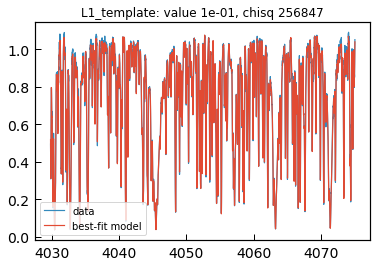

L1_template: value 1e-01, chisq 256847


100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


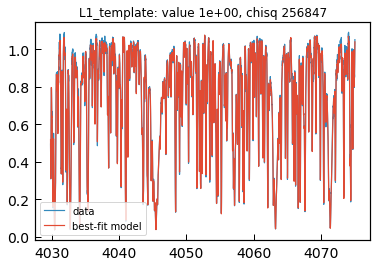

L1_template: value 1e+00, chisq 256847


100%|██████████| 100/100 [00:04<00:00, 24.39it/s]


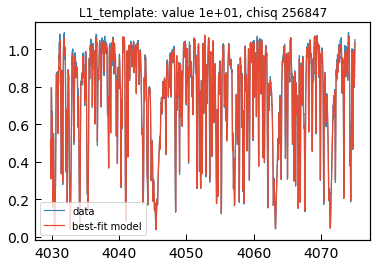

L1_template: value 1e+01, chisq 256847


100%|██████████| 100/100 [00:07<00:00, 13.59it/s]


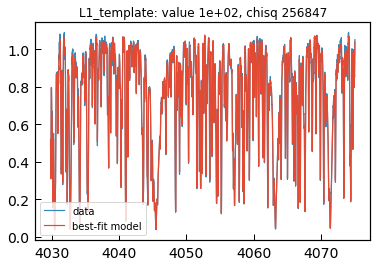

L1_template: value 1e+02, chisq 256847


100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


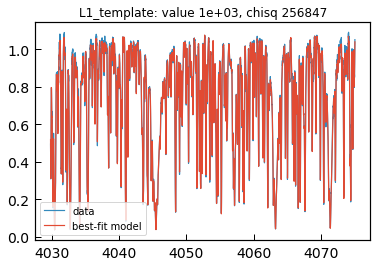

L1_template: value 1e+03, chisq 256847


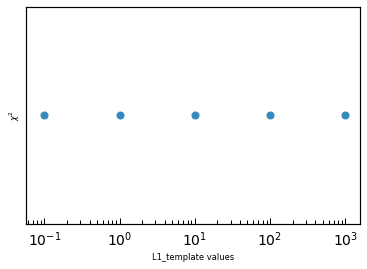

L1_template optimized; setting to 1e-01


100%|██████████| 100/100 [00:06<00:00, 14.90it/s]


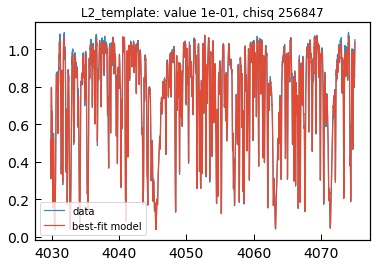

L2_template: value 1e-01, chisq 256847


100%|██████████| 100/100 [00:07<00:00, 13.91it/s]


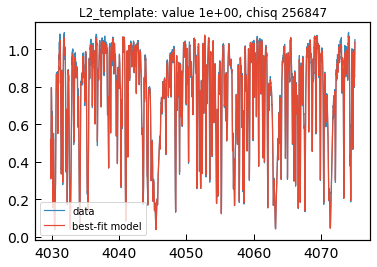

L2_template: value 1e+00, chisq 256847


 73%|███████▎  | 73/100 [00:28<00:10,  2.58it/s]

KeyboardInterrupt: 

In [6]:
%%time
improve_regularization(model.components[0], model, data, 0, names=None)

In [7]:
%%time
improve_regularization(model.components[1], model, data, 0, names=None)

100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


NameError: name 'niter' is not defined

In [7]:
results

NameError: name 'results' is not defined